## Data

Segment lungs and measuring important clinical parameters (lung volume, PD, etc).Kaggle Data Science Bowl 2017 (https://www.kaggle.com/c/data-science-bowl-2017) involve processing and trying to find lesions in CT images of the lungs. In order to find disease in these images well, it is important to first find the lungs well. This dataset is a collection of 2D and 3D images with manually segmented lungs.

### Acknowledgement

https://www.kaggle.com/datasets/kmader/finding-lungs-in-ct-data

### Preprocessing

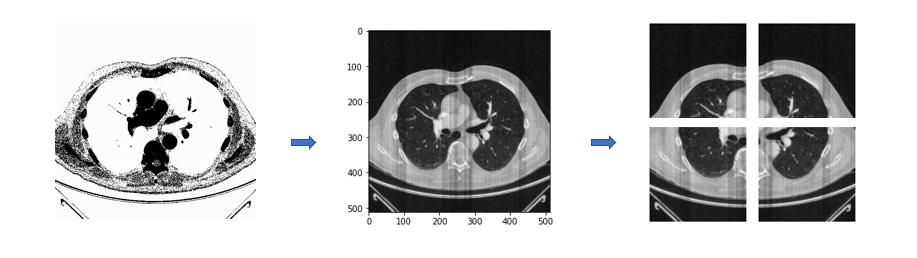

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tifffile as tifffile
from keras.models import load_model
from patchify import patchify, unpatchify
from sklearn.preprocessing import MinMaxScaler
from skimage import measure, color, io,img_as_ubyte
import cv2

model = load_model("./CT_MV2_unet.hdf5", compile=False)

In [2]:
def Predict(image_path):
    I = tifffile.imread(image_path)
    img = scaler.fit_transform(I.reshape(-1, I.shape[-1])).reshape(I.shape)
    S_img = np.stack((img,)*3, axis=-1)
    Image=img_as_ubyte(S_img.astype(np.float32))/255.
    patches = patchify(Image, (256,256,3), step=64)
    
    P = []
    for i in range(patches.shape[0]):
        for j in range(patches.shape[1]):
        
            P_img = patches[i,j,:,:,:]
            img_prediction = (model.predict(P_img)[0,:,:,0] > 0.5).astype(np.uint8)
            P.append(img_prediction)
        
    P_reshaped = np.reshape(np.array(P), (patches.shape[0], patches.shape[1],256,256))
    R_image = unpatchify(P_reshaped, Image[:,:,0].shape)
    
    return R_image

scaler=MinMaxScaler()
mask=cv2.imread('./2d_masks/ID_0000_Z_0142.tif',0)/255.
img_path = './2d_images/ID_0000_Z_0142.tif'
predicted_img = Predict(img_path)

In [3]:
path='./result.jpg'
def watershed(img_path):
    img = cv2.imread(img_path)
    gray = img[:,:,0]
    ret1, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    kernel = np.ones((3,3),np.uint8)
    opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 10)
    sure_bg = cv2.dilate(opening,kernel,iterations=5)

    dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
    ret2, sure_fg = cv2.threshold(dist_transform, 0.2*dist_transform.max(),255,0)

    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg,sure_fg)

    ret3, markers = cv2.connectedComponents(sure_fg)
    markers = markers+10
    markers[unknown==255] = 0
    markers = cv2.watershed(img, markers)
    #The boundary region will be marked -1
    #https://docs.opencv.org/3.3.1/d7/d1b/group__imgproc__misc.html#ga3267243e4d3f95165d55a618c65ac6e1
    F_img = color.label2rgb(markers, bg_label=-1)
    
    return F_img,gray,markers

I,G,M=watershed(path)

IoU Score: 0.9595787412870669


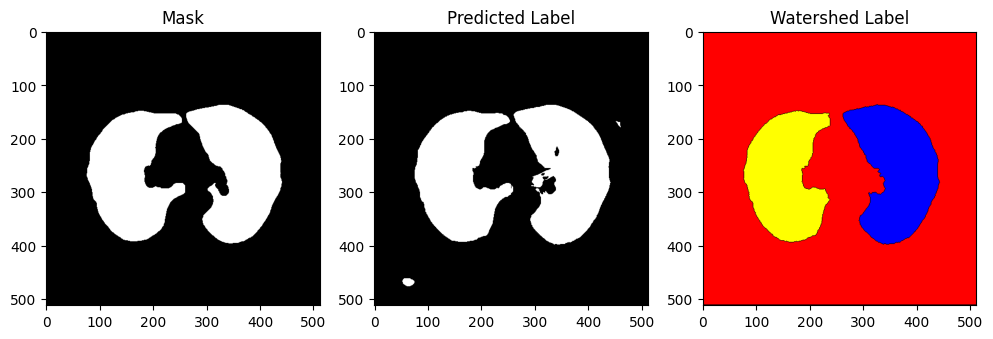

In [4]:
plt.figure(figsize=(12,8))
plt.subplot(131)
plt.imshow(mask,cmap='gray')
plt.title('Mask')
plt.subplot(132)
plt.imshow(predicted_img,cmap='gray')
plt.title('Predicted Label')
plt.subplot(133)
plt.imshow(I)
plt.title('Watershed Label')

Int = np.logical_and(mask, predicted_img)
iou = np.sum(Int) / ((np.sum(mask)+np.sum(predicted_img))- np.sum(Int))
print('IoU Score: %s' % iou)

In [5]:
props = measure.regionprops_table(M, intensity_image=G, 
                              properties=['label',
                                          'area', 'equivalent_diameter',
                                          'mean_intensity', 'solidity'])  
import pandas as pd
df = pd.DataFrame(props)

#Remove background
df = df[df.mean_intensity > 100]  
print(df.head())

   label   area  equivalent_diameter  mean_intensity  solidity
1     11  28976           192.076519      253.645086  0.830639
2     12  27266           186.322702      254.656349  0.840868
